## Import thư viện

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import json
import os

## Model

In [ ]:
# For Resnet34 and below

class BuildingBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BuildingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
# For Resnet50 and above

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out


In [ ]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, kernel_size=7, stride=2, padding=3, num_classes=1000):
        super(Resnet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #ImageNet

        self.conv2_x = self.make_layer(block, 64, num_blocks[0])
        self.conv3_x = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.conv4_x = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.conv5_x = self.make_layer(block, 512, num_blocks[3], stride=2) #ImageNet

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = block.expansion * out_channels
        for idx in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x) #ImageNet

        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x) #ImageNet

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
class Resnet18(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=BuildingBlock,
            num_blocks=[2, 2, 2, 2],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet34(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=BuildingBlock,
            num_blocks=[3, 4, 6, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet50(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 4, 6, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet101(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 4, 23, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet152(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 8, 36, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

In [ ]:
# model = Resnet50(kernel_size=3, stride=1, padding=1, num_classes=100)
# torchsummary.summary(model)
# x = torch.randn(5, 3, 32, 32)
# out = model(x)
# out.shape

## Cifar100

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 169M/169M [00:03<00:00, 48.3MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


### Config

In [ ]:
checkpoint_id = 2
folder_path = f'./Resnet/Cifar100/checkpoint{checkpoint_id}/'
kernel_size = 3
stride = 1
padding = 1
num_classes = len(trainset.classes)
batch_size = 256
num_epochs = 100
learning_rate = 0.001
step_size = 50

os.makedirs(folder_path, exist_ok=True)

config = {
    "checkpoint_id": checkpoint_id,
    "folder_path": folder_path,
    "model": 'Resnet34',
    "kernel_size": kernel_size,
    "stride": stride,
    "padding": padding,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "step_size": step_size
}

with open(folder_path + "config.json", "w") as f:
    json.dump(config, f, indent=4)

In [ ]:
model = Resnet18(kernel_size, stride, padding, num_classes).to(device)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
print(model)

Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2_x): Sequential(
    (0): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), 

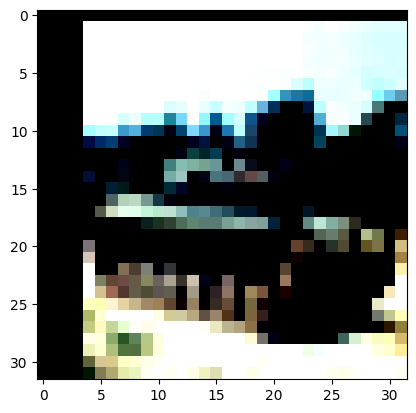

In [ ]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

image = images[0].permute(1, 2, 0).numpy()

plt.imshow(image)

In [ ]:
print(f'Size: {image.size}')
print(f'Train: {len(trainset)}')
print(f'Test: {len(testset)}')
print(f'Classes: {len(trainset.classes)}')

Size: 3072
Train: 50000
Test: 10000
Classes: 100


### Train, test

In [ ]:
def train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=10):
    model.train()
    epoch_losses = []
    start = time.time()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # print(i)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        running_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        epoch_losses.append(running_loss)
        scheduler.step()
    end = time.time()
    training_time = (end - start) / 3600

    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.title('Training Loss per Epoch')
    plt.suptitle(f'Training time: {training_time:.2f} hours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(folder_path + 'training_loss.png')
    plt.show()

    torch.save(model.state_dict(), folder_path + 'model_weights.pth')

def evaluate(model, testloader, device, folder_path):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    correct = sum([1 for a, p in zip(all_labels, all_predictions) if a == p])
    total = len(all_labels)
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:")
    print(report)

    with open(folder_path + 'report.txt', "w") as f:
        f.write(f'Accuracy: {accuracy:.2f}%\n')
        f.write("Classification Report:\n\n")
        f.write(report)


  1%|          | 1/100 [00:42<1:09:52, 42.35s/it]

Epoch [1/100], Loss: 3.7382


  2%|▏         | 2/100 [01:23<1:08:28, 41.92s/it]

Epoch [2/100], Loss: 3.0161


  3%|▎         | 3/100 [02:05<1:07:45, 41.91s/it]

Epoch [3/100], Loss: 2.5660


  4%|▍         | 4/100 [02:48<1:07:18, 42.07s/it]

Epoch [4/100], Loss: 2.2561


  5%|▌         | 5/100 [03:30<1:06:46, 42.18s/it]

Epoch [5/100], Loss: 2.0199


  6%|▌         | 6/100 [04:13<1:06:17, 42.32s/it]

Epoch [6/100], Loss: 1.8547


  7%|▋         | 7/100 [04:55<1:05:51, 42.49s/it]

Epoch [7/100], Loss: 1.7217


  8%|▊         | 8/100 [05:38<1:05:17, 42.58s/it]

Epoch [8/100], Loss: 1.6038


  9%|▉         | 9/100 [06:21<1:04:47, 42.71s/it]

Epoch [9/100], Loss: 1.5222


 10%|█         | 10/100 [07:04<1:04:10, 42.78s/it]

Epoch [10/100], Loss: 1.4494


 11%|█         | 11/100 [07:47<1:03:32, 42.84s/it]

Epoch [11/100], Loss: 1.3687


 12%|█▏        | 12/100 [08:30<1:02:49, 42.83s/it]

Epoch [12/100], Loss: 1.3034


 13%|█▎        | 13/100 [09:13<1:02:10, 42.88s/it]

Epoch [13/100], Loss: 1.2551


 14%|█▍        | 14/100 [09:56<1:01:30, 42.92s/it]

Epoch [14/100], Loss: 1.2022


 15%|█▌        | 15/100 [10:39<1:00:46, 42.89s/it]

Epoch [15/100], Loss: 1.1517


 16%|█▌        | 16/100 [11:22<1:00:10, 42.98s/it]

Epoch [16/100], Loss: 1.1159


 17%|█▋        | 17/100 [12:05<59:28, 43.00s/it]  

Epoch [17/100], Loss: 1.0752


 18%|█▊        | 18/100 [12:48<58:43, 42.97s/it]

Epoch [18/100], Loss: 1.0443


 19%|█▉        | 19/100 [13:31<57:58, 42.94s/it]

Epoch [19/100], Loss: 1.0110


 20%|██        | 20/100 [14:14<57:17, 42.97s/it]

Epoch [20/100], Loss: 0.9849


 21%|██        | 21/100 [14:57<56:30, 42.92s/it]

Epoch [21/100], Loss: 0.9505


 22%|██▏       | 22/100 [15:39<55:45, 42.90s/it]

Epoch [22/100], Loss: 0.9302


 23%|██▎       | 23/100 [16:23<55:08, 42.97s/it]

Epoch [23/100], Loss: 0.9080


 24%|██▍       | 24/100 [17:06<54:23, 42.94s/it]

Epoch [24/100], Loss: 0.8917


 25%|██▌       | 25/100 [17:48<53:34, 42.87s/it]

Epoch [25/100], Loss: 0.8650


 26%|██▌       | 26/100 [18:31<52:46, 42.80s/it]

Epoch [26/100], Loss: 0.8508


 27%|██▋       | 27/100 [19:14<52:08, 42.85s/it]

Epoch [27/100], Loss: 0.8293


 28%|██▊       | 28/100 [19:57<51:23, 42.82s/it]

Epoch [28/100], Loss: 0.8173


 29%|██▉       | 29/100 [20:39<50:34, 42.74s/it]

Epoch [29/100], Loss: 0.7995


 30%|███       | 30/100 [21:22<49:56, 42.80s/it]

Epoch [30/100], Loss: 0.7854


 31%|███       | 31/100 [22:05<49:11, 42.78s/it]

Epoch [31/100], Loss: 0.7699


 32%|███▏      | 32/100 [22:47<48:23, 42.70s/it]

Epoch [32/100], Loss: 0.7636


 33%|███▎      | 33/100 [23:30<47:43, 42.74s/it]

Epoch [33/100], Loss: 0.7446


 34%|███▍      | 34/100 [24:13<46:59, 42.72s/it]

Epoch [34/100], Loss: 0.7302


 35%|███▌      | 35/100 [24:55<46:15, 42.70s/it]

Epoch [35/100], Loss: 0.7193


 36%|███▌      | 36/100 [25:38<45:30, 42.66s/it]

Epoch [36/100], Loss: 0.7047


 37%|███▋      | 37/100 [26:21<44:51, 42.72s/it]

Epoch [37/100], Loss: 0.7025


 38%|███▊      | 38/100 [27:03<44:03, 42.64s/it]

Epoch [38/100], Loss: 0.6954


 39%|███▉      | 39/100 [27:46<43:21, 42.65s/it]

Epoch [39/100], Loss: 0.6866


 40%|████      | 40/100 [28:29<42:38, 42.64s/it]

Epoch [40/100], Loss: 0.6733


 41%|████      | 41/100 [29:11<41:50, 42.55s/it]

Epoch [41/100], Loss: 0.6713


 42%|████▏     | 42/100 [29:54<41:11, 42.61s/it]

Epoch [42/100], Loss: 0.6526


 43%|████▎     | 43/100 [30:36<40:26, 42.58s/it]

Epoch [43/100], Loss: 0.6498


 44%|████▍     | 44/100 [31:19<39:41, 42.53s/it]

Epoch [44/100], Loss: 0.6473


 45%|████▌     | 45/100 [32:01<39:03, 42.60s/it]

Epoch [45/100], Loss: 0.6331


 46%|████▌     | 46/100 [32:44<38:18, 42.56s/it]

Epoch [46/100], Loss: 0.6263


 47%|████▋     | 47/100 [33:26<37:31, 42.49s/it]

Epoch [47/100], Loss: 0.6142


 48%|████▊     | 48/100 [34:09<36:50, 42.52s/it]

Epoch [48/100], Loss: 0.6256


 49%|████▉     | 49/100 [34:51<36:08, 42.52s/it]

Epoch [49/100], Loss: 0.6091


 50%|█████     | 50/100 [35:34<35:23, 42.47s/it]

Epoch [50/100], Loss: 0.6076


 51%|█████     | 51/100 [36:16<34:42, 42.51s/it]

Epoch [51/100], Loss: 0.3815


 52%|█████▏    | 52/100 [36:59<34:04, 42.60s/it]

Epoch [52/100], Loss: 0.2969


 53%|█████▎    | 53/100 [37:42<33:20, 42.56s/it]

Epoch [53/100], Loss: 0.2585


 54%|█████▍    | 54/100 [38:24<32:37, 42.55s/it]

Epoch [54/100], Loss: 0.2327


 55%|█████▌    | 55/100 [39:06<31:51, 42.48s/it]

Epoch [55/100], Loss: 0.2116


 56%|█████▌    | 56/100 [39:49<31:08, 42.46s/it]

Epoch [56/100], Loss: 0.1997


 57%|█████▋    | 57/100 [40:31<30:26, 42.47s/it]

Epoch [57/100], Loss: 0.1810


 58%|█████▊    | 58/100 [41:14<29:41, 42.42s/it]

Epoch [58/100], Loss: 0.1688


 59%|█████▉    | 59/100 [41:56<29:03, 42.52s/it]

Epoch [59/100], Loss: 0.1578


 60%|██████    | 60/100 [42:39<28:19, 42.48s/it]

Epoch [60/100], Loss: 0.1471


 61%|██████    | 61/100 [43:21<27:36, 42.48s/it]

Epoch [61/100], Loss: 0.1382


 62%|██████▏   | 62/100 [44:04<26:52, 42.43s/it]

Epoch [62/100], Loss: 0.1279


 63%|██████▎   | 63/100 [44:46<26:10, 42.45s/it]

Epoch [63/100], Loss: 0.1199


 64%|██████▍   | 64/100 [45:28<25:27, 42.43s/it]

Epoch [64/100], Loss: 0.1141


 65%|██████▌   | 65/100 [46:11<24:45, 42.44s/it]

Epoch [65/100], Loss: 0.1074


 66%|██████▌   | 66/100 [46:54<24:06, 42.54s/it]

Epoch [66/100], Loss: 0.0986


 67%|██████▋   | 67/100 [47:36<23:22, 42.51s/it]

Epoch [67/100], Loss: 0.0991


 68%|██████▊   | 68/100 [48:18<22:38, 42.45s/it]

Epoch [68/100], Loss: 0.0885


 69%|██████▉   | 69/100 [49:01<21:56, 42.46s/it]

Epoch [69/100], Loss: 0.0873


 70%|███████   | 70/100 [49:43<21:14, 42.47s/it]

Epoch [70/100], Loss: 0.0831


 71%|███████   | 71/100 [50:26<20:31, 42.45s/it]

Epoch [71/100], Loss: 0.0796


 72%|███████▏  | 72/100 [51:08<19:50, 42.53s/it]

Epoch [72/100], Loss: 0.0761


 73%|███████▎  | 73/100 [51:51<19:09, 42.59s/it]

Epoch [73/100], Loss: 0.0741


 74%|███████▍  | 74/100 [52:34<18:27, 42.61s/it]

Epoch [74/100], Loss: 0.0701


 75%|███████▌  | 75/100 [53:16<17:44, 42.59s/it]

Epoch [75/100], Loss: 0.0705


 76%|███████▌  | 76/100 [53:59<17:01, 42.57s/it]

Epoch [76/100], Loss: 0.0661


 77%|███████▋  | 77/100 [54:41<16:17, 42.48s/it]

Epoch [77/100], Loss: 0.0662


 78%|███████▊  | 78/100 [55:24<15:35, 42.55s/it]

Epoch [78/100], Loss: 0.0647


 79%|███████▉  | 79/100 [56:07<14:53, 42.56s/it]

Epoch [79/100], Loss: 0.0607


 80%|████████  | 80/100 [56:49<14:11, 42.57s/it]

Epoch [80/100], Loss: 0.0632


 81%|████████  | 81/100 [57:32<13:30, 42.64s/it]

Epoch [81/100], Loss: 0.0594


 82%|████████▏ | 82/100 [58:14<12:47, 42.62s/it]

Epoch [82/100], Loss: 0.0593


 83%|████████▎ | 83/100 [58:57<12:04, 42.60s/it]

Epoch [83/100], Loss: 0.0564


 84%|████████▍ | 84/100 [59:40<11:21, 42.61s/it]

Epoch [84/100], Loss: 0.0564


 85%|████████▌ | 85/100 [1:00:22<10:38, 42.55s/it]

Epoch [85/100], Loss: 0.0572


 86%|████████▌ | 86/100 [1:01:05<09:56, 42.60s/it]

Epoch [86/100], Loss: 0.0549


 87%|████████▋ | 87/100 [1:01:47<09:13, 42.58s/it]

Epoch [87/100], Loss: 0.0526


 88%|████████▊ | 88/100 [1:02:30<08:30, 42.54s/it]

Epoch [88/100], Loss: 0.0526


 89%|████████▉ | 89/100 [1:03:12<07:47, 42.51s/it]

Epoch [89/100], Loss: 0.0500


 90%|█████████ | 90/100 [1:03:55<07:05, 42.50s/it]

Epoch [90/100], Loss: 0.0522


 91%|█████████ | 91/100 [1:04:37<06:22, 42.46s/it]

Epoch [91/100], Loss: 0.0515


 92%|█████████▏| 92/100 [1:05:20<05:39, 42.48s/it]

Epoch [92/100], Loss: 0.0501


 93%|█████████▎| 93/100 [1:06:02<04:57, 42.49s/it]

Epoch [93/100], Loss: 0.0511


 94%|█████████▍| 94/100 [1:06:44<04:14, 42.45s/it]

Epoch [94/100], Loss: 0.0482


 95%|█████████▌| 95/100 [1:07:27<03:32, 42.57s/it]

Epoch [95/100], Loss: 0.0466


 96%|█████████▌| 96/100 [1:08:10<02:50, 42.56s/it]

Epoch [96/100], Loss: 0.0499


 97%|█████████▋| 97/100 [1:08:52<02:07, 42.53s/it]

Epoch [97/100], Loss: 0.0504


 98%|█████████▊| 98/100 [1:09:35<01:25, 42.60s/it]

Epoch [98/100], Loss: 0.0504


 99%|█████████▉| 99/100 [1:10:18<00:42, 42.59s/it]

Epoch [99/100], Loss: 0.0470


100%|██████████| 100/100 [1:11:00<00:00, 42.61s/it]

Epoch [100/100], Loss: 0.0460


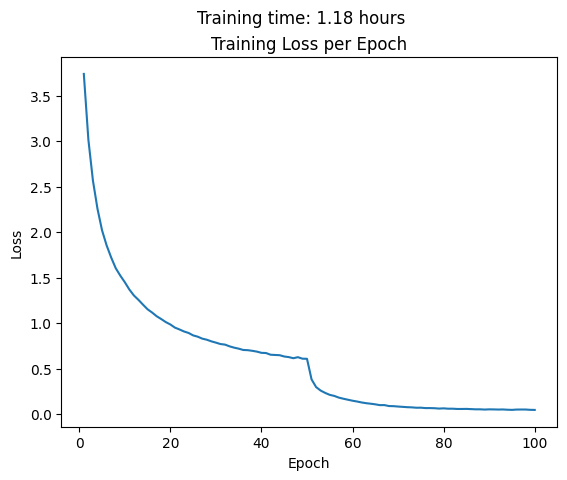

In [ ]:
train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=num_epochs)

In [ ]:
evaluate(model, testloader, device, folder_path)

Accuracy: 71.89%
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       100
           1       0.83      0.85      0.84       100
           2       0.57      0.67      0.61       100
           3       0.58      0.57      0.58       100
           4       0.50      0.58      0.54       100
           5       0.77      0.70      0.73       100
           6       0.79      0.78      0.78       100
           7       0.84      0.72      0.77       100
           8       0.89      0.81      0.85       100
           9       0.88      0.83      0.86       100
          10       0.57      0.55      0.56       100
          11       0.50      0.49      0.49       100
          12       0.85      0.71      0.77       100
          13       0.69      0.73      0.71       100
          14       0.69      0.68      0.69       100
          15       0.81      0.71      0.76       100
          16       0.80      0.76      0.